# Peer-graded Assignment: Эксперименты с моделью

На прошлой неделе вы поучаствовали в соревновании на kaggle и, наверняка, большинство успешно справилось с прохождением baseline, а значит пора двигаться дальше - заняться оптимизацией модели, провести серию экспериментов и построить сильное финальное решения.

В этом задании вам нужно провести ряд эскпериментов, оценить качество полученных в процессе экспериментирования моделей и выбрать лучшее решение. 

Задание будет оцениваться на основании загруженного jupyther notebook и развернутых ответов на поставленные вопросы.

## Инструкции

1\. Начнем с простого. Давайте оценим как много объектов действительно нужно для построения качественной модели. Для обучения доступна достаточно большая выборка и может так оказаться, что начиная с некоторого момента рост размера обучающей выборки перестает влиять на качество модели. Постройте кривые обучения, обучая модель на выборках разного размера начиная с небольшого количество объектов в обучающей выборке и постепенно наращивая её размер с некоторым шагом. Обратите внимание на `sklearn.model_selection.learning_curve`

In [242]:
#cначала загрузим данные и подготовим модель с прошлой недели
import pandas as pd
import numpy as np
data = pd.read_csv('orange_small_churn_data.csv', delimiter =',')
data['labels'] = pd.read_csv('orange_small_churn_labels.csv', header=None)
#конвертируем колонку labels в int
data = data.astype({'labels': 'int32'})
#заменим все -1 в целевой переменной на 0
data['labels'] = data['labels'].map({1: 1, -1: 0})
from sklearn.model_selection import train_test_split
data, test = train_test_split(data, test_size=0.15, random_state=42)
target = np.array(data.iloc[:,-1])
target_test = np.array(test.iloc[:,-1])
#подготовим даные:
#выделим категориальные признаки (для baseline решения, возможно будет достаточно числовых)
numericalVarCount = 190
categorialVarCount = 40

data_num = data.iloc[:, 0:numericalVarCount]
#удалим числовые признаки, содержащие слишком большое количество NaN - значений
threshold = 0.7
NaN_frac = data_num.isna().sum(axis = 0)/data_num.shape[0]
numVarsToStay = list(NaN_frac[NaN_frac < threshold].index)
data_num = data_num.loc[:,numVarsToStay]
#Перед построением моделей, подготовим данные: заменим NaN на медианные значения,
medians = data_num.median()
data_num.fillna(medians, inplace=True)
#выполним стандартизацию числовых признаков
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_num = scaler.fit_transform(data_num)

# #обработаем категориальные признаки методикой one-hot-encoding
from sklearn.feature_extraction import DictVectorizer as DV
data_cat = data.iloc[:, numericalVarCount:-1]

data_cat_oh = pd.get_dummies(data_cat, dummy_na=True, drop_first=True)
NaN_frac = data_cat.isna().sum(axis = 0)/data_cat.shape[0]
NaN_frac
threshold = 0.1
NaN_frac = data_cat.isna().sum(axis = 0)/data_num.shape[0]
catVarsToStay = list(NaN_frac[NaN_frac < threshold].index)
data_cat = data_cat.loc[:,catVarsToStay]
data_cat = data_cat.fillna('NA').astype(str)

#Подсчитаем количество уникальных значений в категориальных признаках, от этого будет зависеть способ кодировки
unique_counts = []
for c in data_cat.columns:
    unique_counts.append(data_cat[c].dropna().unique().shape[0])
cat_unique = pd.DataFrame()
cat_unique['unique_counts'] = unique_counts
cat_unique.index = data_cat.columns
cat_unique.sort_values(by='unique_counts', ascending=False)
cat_unique

cat_feat_for_OHE = list(cat_unique[cat_unique['unique_counts'] < 50].index)
cat_feat_for_OHE
encoder = DV(sparse = False)
data_cat_oh = encoder.fit_transform(data_cat[cat_feat_for_OHE].T.to_dict().values())

data_all = np.hstack((data_num,data_cat_oh))
data_all.shape

#выполняем на ней ту же обработку, что для набора обучения
test_num = test.iloc[:, 0:numericalVarCount]
#выкинем признаки, которые выкидывали при обучении
test_num = test.loc[:,numVarsToStay]
#заполним NaN медианными значениями train!!! набора
test_num.fillna(medians, inplace=True)
#выполним стандартизацию, с теми же параметрами, что при обучении:
test_num = scaler.transform(test_num)
test_cat = test.iloc[:, numericalVarCount:-1]
test_cat = test_cat.loc[:,catVarsToStay]
test_cat = test_cat.fillna('NA').astype(str)
test_cat_oh = encoder.transform(test_cat[cat_feat_for_OHE].T.to_dict().values())
test_all = np.hstack((test_num,test_cat_oh))


#будем использовать следующие модели для baseline решения:
#RandomForestClassifier, RidgeClassifier и SGDClassifier
#ввиду несбалансированности выборок везде используем class_weight='balanced'
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
clf = SGDClassifier(loss = 'log', class_weight='balanced', max_iter=1000, tol=1e-4, alpha=0.01, random_state=42)

scores = cross_val_score(clf, data_all, target, cv=3, scoring = 'f1')
basic_score = scores.mean()

# clf.fit(data_all, target)

In [243]:
#используем подготовленные данные и модель для построения кривых обучения
from sklearn.model_selection import learning_curve
train_sizes=np.linspace(.1, 1.0, 5)
train_sizes, train_scores, test_scores = learning_curve(clf, data_all, target,train_sizes=train_sizes, n_jobs=1, cv= None,scoring = 'f1')

In [244]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_mean

array([ 0.26900179,  0.20142836,  0.20030722,  0.19814001,  0.20743172])

In [245]:
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_mean

array([ 0.18030355,  0.18540377,  0.19096725,  0.19257354,  0.19898689])

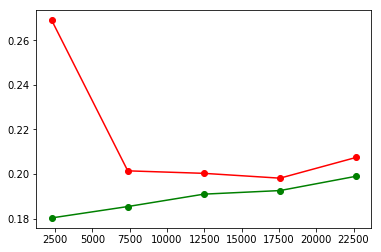

In [246]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

Вывод: похоже, если добавить еще данных при обучении, можно улучшить результат

2\. Часто несбалансированные по классам выборки приводят к различным проблемам при обучении моделей. Давайте попробуем по-разному обработать выборку, поиграть с распределением объектов по классам и сделать выводы о том, как соотношение классов влияет на качество модели.

2.1\. Задайте веса объектам так, чтобы соотношение классов с учетом весов объектов изменилось. Попробуйте не менее трёх различных вариантов весов. Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [248]:
#в моделе с прошлой недели уже были использованны веса (параметр class_weight='balanced)
#таким образом, один из способов учета весов уже применен, осталось применить еще 2
# scores = cross_val_score(clf, data_all, target, cv=3, scoring = 'f1')
# score_modelWeights = scores.mean()
from sklearn.metrics import f1_score
clf.fit(data_all, target)
test_pred = clf.predict(test_all)
score_modelWeights = f1_score(target_test, test_pred) 

In [249]:
#2. Веса вручную
#т.к. в наших данных клиентов склонных к оттоку грубо 10% размножим их данные, чтобы сбалансировать классы
dataChunr = data_all[target == 1,:]
target = target[:,np.newaxis]
targetChurn = target[target == 1]
targetChurn = targetChurn[:,np.newaxis]
data_all_ForHand = data_all
target_ForHand = target
for i in range(10):
    data_all_ForHand =  np.vstack((data_all_ForHand,dataChunr))
    target_ForHand = np.vstack((target_ForHand,targetChurn))
target_ForHand = target_ForHand.ravel()
target = target.ravel()
# scores = cross_val_score(clf, data_all, target, cv=3, scoring = 'f1')
# score_HandWeights = scores.mean()
clf = SGDClassifier(loss = 'log', max_iter=1000, tol=1e-4, alpha=0.01, random_state=42)
clf.fit(data_all_ForHand, target_ForHand)
test_pred = clf.predict(test_all)
score_HandWeights = f1_score(target_test, test_pred)

In [250]:
#3. Комбинированные веса: когда мы выполняли веса "вручную" мы ПРИМЕРНО сбалансировали выборку,
#поэтому, чтобы сделать веса точнее попробуем оба подхода одновременно
clf = SGDClassifier(loss = 'log', class_weight='balanced', max_iter=1000, tol=1e-4, alpha=0.01, random_state=42)
clf.fit(data_all_ForHand, target_ForHand)
test_pred = clf.predict(test_all)
score_HandWeightsAndModelWeights = f1_score(target_test, test_pred)

In [251]:
#сравним оценки моделей с разными весами
score_modelWeights, score_HandWeights, score_HandWeightsAndModelWeights

(0.20212443095599394, 0.21720969089390138, 0.21386603995299647)

Вывод: Использование различных методов задания весов влияет на результат незначительно, но любой способ дает лучший результат,
чем без использования весов

2.2\. Примените к выборке технологию undersampling: для этого нужно убрать из обучения некоторое количество объектов большего класса таким образом, чтобы соотношение классов изменилось. Попробуйте не менее трёх различных вариантов undersampling (варианты могут отличаться как по количество отфильтрованных объектов, так и по принципу выборка объектов для отсеивания из выборки). Меняются ли результаты классификации? Как это сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [253]:
#undersampling до равного отношения числа классов
data_Churn = data_all[target == 1,:]
target_Churn = target[target == 1]
data_notChurn = data_all[target == 0,:][:data_Churn.shape[0],:]
target_notChurn = target[target == 0][:data_Churn.shape[0]]
data_all_undersampled = np.vstack((data_Churn, data_notChurn))
target_undersampled = np.vstack((target_Churn[:,np.newaxis], target_notChurn[:,np.newaxis])).ravel()

clf = SGDClassifier(loss = 'log', max_iter=1000, tol=1e-4, alpha=0.01, random_state=42)
clf.fit(data_all_undersampled, target_undersampled)
test_pred = clf.predict(test_all)
score_undersampled1 = f1_score(target_test, test_pred)

#undersampling до отношения числа классов 1:2

data_notChurn = data_all[target == 0,:][:data_Churn.shape[0]*2,:]
target_notChurn = target[target == 0][:data_Churn.shape[0]*2]
data_all_undersampled = np.vstack((data_Churn, data_notChurn))
target_undersampled = np.vstack((target_Churn[:,np.newaxis], target_notChurn[:,np.newaxis])).ravel()

clf = SGDClassifier(loss = 'log', max_iter=1000, tol=1e-4, alpha=0.01, random_state=42)
clf.fit(data_all_undersampled, target_undersampled)
test_pred = clf.predict(test_all)
score_undersampled2 = f1_score(target_test, test_pred)

#undersampling до отношения числа классов 1:3

data_notChurn = data_all[target == 0,:][:data_Churn.shape[0]*3,:]
target_notChurn = target[target == 0][:data_Churn.shape[0]*3]
data_all_undersampled = np.vstack((data_Churn, data_notChurn))
target_undersampled = np.vstack((target_Churn[:,np.newaxis], target_notChurn[:,np.newaxis])).ravel()

clf = SGDClassifier(loss = 'log', max_iter=1000, tol=1e-4, alpha=0.01, random_state=42)
clf.fit(data_all_undersampled, target_undersampled)
test_pred = clf.predict(test_all)
score_undersampled3 = f1_score(target_test, test_pred)

#результаты с разным undersampling'ом
score_undersampled1, score_undersampled2, score_undersampled3

(0.202907915993538, 0.20754716981132074, 0.090909090909090912)

вывод: undersampling нужно обязательно делать таким образом, чтобы классы стали сбалансированны,
иначе улучшения результата не наблюдается

3\. Теперь перейдем к работе с признаками. Ранее вы реализовали несколько стратегий для обработки пропущенных значений. Сравните эти стратегии между собой с помощью оценки качества моделей кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка пропущенных значений сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [255]:
#В исходной модели пропуски числовых переменных заменялись на медианные значения, попробуем теперь заменять на 0:

#cначала загрузим данные и подготовим модель с прошлой недели
import pandas as pd
import numpy as np
data = pd.read_csv('orange_small_churn_data.csv', delimiter =',')
data['labels'] = pd.read_csv('orange_small_churn_labels.csv', header=None)
#конвертируем колонку labels в int
data = data.astype({'labels': 'int32'})
#заменим все -1 в целевой переменной на 0
data['labels'] = data['labels'].map({1: 1, -1: 0})
from sklearn.model_selection import train_test_split
data, test = train_test_split(data, test_size=0.15, random_state=42)
target = np.array(data.iloc[:,-1])
target_test = np.array(test.iloc[:,-1])
#подготовим даные:
#выделим категориальные признаки (для baseline решения, возможно будет достаточно числовых)
numericalVarCount = 190
categorialVarCount = 40

data_num = data.iloc[:, 0:numericalVarCount]
#удалим числовые признаки, содержащие слишком большое количество NaN - значений
threshold = 0.7
NaN_frac = data_num.isna().sum(axis = 0)/data_num.shape[0]
numVarsToStay = list(NaN_frac[NaN_frac < threshold].index)
data_num = data_num.loc[:,numVarsToStay]
#Перед построением моделей, подготовим данные: заменим NaN на медианные значения,
data_num.fillna(0, inplace=True)
#выполним стандартизацию числовых признаков
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_num = scaler.fit_transform(data_num)

# #обработаем категориальные признаки методикой one-hot-encoding
from sklearn.feature_extraction import DictVectorizer as DV
data_cat = data.iloc[:, numericalVarCount:-1]

data_cat_oh = pd.get_dummies(data_cat, dummy_na=True, drop_first=True)
NaN_frac = data_cat.isna().sum(axis = 0)/data_cat.shape[0]
NaN_frac
threshold = 0.1
NaN_frac = data_cat.isna().sum(axis = 0)/data_num.shape[0]
catVarsToStay = list(NaN_frac[NaN_frac < threshold].index)
data_cat = data_cat.loc[:,catVarsToStay]
data_cat = data_cat.fillna('NA').astype(str)

#Подсчитаем количество уникальных значений в категориальных признаках, от этого будет зависеть способ кодировки
unique_counts = []
for c in data_cat.columns:
    unique_counts.append(data_cat[c].dropna().unique().shape[0])
cat_unique = pd.DataFrame()
cat_unique['unique_counts'] = unique_counts
cat_unique.index = data_cat.columns
cat_unique.sort_values(by='unique_counts', ascending=False)
cat_unique

cat_feat_for_OHE = list(cat_unique[cat_unique['unique_counts'] < 50].index)
cat_feat_for_OHE
encoder = DV(sparse = False)
data_cat_oh = encoder.fit_transform(data_cat[cat_feat_for_OHE].T.to_dict().values())

data_all = np.hstack((data_num,data_cat_oh))

clf = SGDClassifier(loss = 'log', class_weight='balanced', max_iter=1000, tol=1e-4, alpha=0.01, random_state=42)

scores = cross_val_score(clf, data_all, target, cv=3, scoring = 'f1')
with_zeros_score = scores.mean()
basic_score, with_zeros_score

(0.20253190381202768, 0.19818173806276984)

Вывод: замена пропущенных числовых значений на 0 дает примерно такое же качество модели, как и замена на медианное значение

4\. Также вы уже реализовали несколько стратегий для обработки категориальных признаков. Сравните эти стратегии между собой с помощью оценки качества моделей по кросс-валидации, построенных на датасетах с использованием различных стратегий. Как обработка категориальных признаков сказывается на качестве модели? Какой вариант выглядит наиболее оптимальным с точки зрения качества?

In [256]:
#в решении с прошлой недели обрабатывались только категориальные признаки с количеством категорий меньше 50 при помощи
# one-hot-encoding сравним качество модели, если обрабатывать только признаки с количеством категорий меньше 5
data = pd.read_csv('orange_small_churn_data.csv', delimiter =',')
data['labels'] = pd.read_csv('orange_small_churn_labels.csv', header=None)
#конвертируем колонку labels в int
data = data.astype({'labels': 'int32'})
#заменим все -1 в целевой переменной на 0
data['labels'] = data['labels'].map({1: 1, -1: 0})
from sklearn.model_selection import train_test_split
data, test = train_test_split(data, test_size=0.15, random_state=42)
target = np.array(data.iloc[:,-1])
target_test = np.array(test.iloc[:,-1])
#подготовим даные:
#выделим категориальные признаки (для baseline решения, возможно будет достаточно числовых)
numericalVarCount = 190
categorialVarCount = 40

data_num = data.iloc[:, 0:numericalVarCount]
#удалим числовые признаки, содержащие слишком большое количество NaN - значений
threshold = 0.7
NaN_frac = data_num.isna().sum(axis = 0)/data_num.shape[0]
numVarsToStay = list(NaN_frac[NaN_frac < threshold].index)
data_num = data_num.loc[:,numVarsToStay]
#Перед построением моделей, подготовим данные: заменим NaN на медианные значения,
medians = data_num.median()
data_num.fillna(medians, inplace=True)
#выполним стандартизацию числовых признаков
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_num = scaler.fit_transform(data_num)

# #обработаем категориальные признаки методикой one-hot-encoding
from sklearn.feature_extraction import DictVectorizer as DV
data_cat = data.iloc[:, numericalVarCount:-1]

data_cat_oh = pd.get_dummies(data_cat, dummy_na=True, drop_first=True)
NaN_frac = data_cat.isna().sum(axis = 0)/data_cat.shape[0]
NaN_frac
threshold = 0.1
NaN_frac = data_cat.isna().sum(axis = 0)/data_num.shape[0]
catVarsToStay = list(NaN_frac[NaN_frac < threshold].index)
data_cat = data_cat.loc[:,catVarsToStay]
data_cat = data_cat.fillna('NA').astype(str)

#Подсчитаем количество уникальных значений в категориальных признаках, от этого будет зависеть способ кодировки
unique_counts = []
for c in data_cat.columns:
    unique_counts.append(data_cat[c].dropna().unique().shape[0])
cat_unique = pd.DataFrame()
cat_unique['unique_counts'] = unique_counts
cat_unique.index = data_cat.columns
cat_unique.sort_values(by='unique_counts', ascending=False)
cat_unique

cat_feat_for_OHE = list(cat_unique[cat_unique['unique_counts'] < 5].index)
cat_feat_for_OHE
encoder = DV(sparse = False)
data_cat_oh = encoder.fit_transform(data_cat[cat_feat_for_OHE].T.to_dict().values())

data_all = np.hstack((data_num,data_cat_oh))

scores = cross_val_score(clf, data_all, target, cv=3, scoring = 'f1')
cat5_score = scores.mean()
basic_score, cat5_score

(0.20253190381202768, 0.19176117617552371)

вывод: обработка категориальных признаком с количеством категорий до 50 дает немного лучший результат по сравнению с обработкой
категорий с 5 различными признаками

5\. Все ли признаки оказались полезными для построения моделей? Проведите процедуру отбора признаков, попробуйте разные варианты отбора (обратите внимание на модуль `sklearn.feature_selection`). Например, можно выбрасывать случайные признаки или строить отбор на основе l1-регуляризации - отфильтровать из обучения признаки, которые получат нулевой вес при построении регрессии с l1-регуляризацией (`sklearn.linear_model.Lasso`). И всегда можно придумать что-то своё=) Попробуйте как минимум 2 различные стратегии, сравните результаты. Помог ли отбор признаков улучшить качество модели? Поясните свой ответ.

In [258]:
data = pd.read_csv('orange_small_churn_data.csv', delimiter =',')
data['labels'] = pd.read_csv('orange_small_churn_labels.csv', header=None)
#конвертируем колонку labels в int
data = data.astype({'labels': 'int32'})
#заменим все -1 в целевой переменной на 0
data['labels'] = data['labels'].map({1: 1, -1: 0})
from sklearn.model_selection import train_test_split
data, test = train_test_split(data, test_size=0.15, random_state=42)
target = np.array(data.iloc[:,-1])
target_test = np.array(test.iloc[:,-1])
#подготовим даные:
#выделим категориальные признаки (для baseline решения, возможно будет достаточно числовых)
numericalVarCount = 190
categorialVarCount = 40

data_num = data.iloc[:, 0:numericalVarCount]
#удалим числовые признаки, содержащие слишком большое количество NaN - значений
threshold = 0.7
NaN_frac = data_num.isna().sum(axis = 0)/data_num.shape[0]
numVarsToStay = list(NaN_frac[NaN_frac < threshold].index)
data_num = data_num.loc[:,numVarsToStay]
#Перед построением моделей, подготовим данные: заменим NaN на медианные значения,
medians = data_num.median()
data_num.fillna(medians, inplace=True)
#выполним стандартизацию числовых признаков
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_num = scaler.fit_transform(data_num)

# #обработаем категориальные признаки методикой one-hot-encoding
from sklearn.feature_extraction import DictVectorizer as DV
data_cat = data.iloc[:, numericalVarCount:-1]

data_cat_oh = pd.get_dummies(data_cat, dummy_na=True, drop_first=True)
NaN_frac = data_cat.isna().sum(axis = 0)/data_cat.shape[0]
NaN_frac
threshold = 0.1
NaN_frac = data_cat.isna().sum(axis = 0)/data_num.shape[0]
catVarsToStay = list(NaN_frac[NaN_frac < threshold].index)
data_cat = data_cat.loc[:,catVarsToStay]
data_cat = data_cat.fillna('NA').astype(str)

#Подсчитаем количество уникальных значений в категориальных признаках, от этого будет зависеть способ кодировки
unique_counts = []
for c in data_cat.columns:
    unique_counts.append(data_cat[c].dropna().unique().shape[0])
cat_unique = pd.DataFrame()
cat_unique['unique_counts'] = unique_counts
cat_unique.index = data_cat.columns
cat_unique.sort_values(by='unique_counts', ascending=False)
cat_unique

cat_feat_for_OHE = list(cat_unique[cat_unique['unique_counts'] < 50].index)
cat_feat_for_OHE
encoder = DV(sparse = False)
data_cat_oh = encoder.fit_transform(data_cat[cat_feat_for_OHE].T.to_dict().values())

data_all = np.hstack((data_num,data_cat_oh))
data_all.shape

#выполняем на ней ту же обработку, что для набора обучения
test_num = test.iloc[:, 0:numericalVarCount]
#выкинем признаки, которые выкидывали при обучении
test_num = test.loc[:,numVarsToStay]
#заполним NaN медианными значениями train!!! набора
test_num.fillna(medians, inplace=True)
#выполним стандартизацию, с теми же параметрами, что при обучении:
test_num = scaler.transform(test_num)
test_cat = test.iloc[:, numericalVarCount:-1]
test_cat = test_cat.loc[:,catVarsToStay]
test_cat = test_cat.fillna('NA').astype(str)
test_cat_oh = encoder.transform(test_cat[cat_feat_for_OHE].T.to_dict().values())
test_all = np.hstack((test_num,test_cat_oh))

#балансировка вручную
dataChunr = data_all[target == 1,:]
target = target[:,np.newaxis]
targetChurn = target[target == 1]
targetChurn = targetChurn[:,np.newaxis]
data_all_ForHand = data_all
target_ForHand = target
for i in range(10):
    data_all_ForHand =  np.vstack((data_all_ForHand,dataChunr))
    target_ForHand = np.vstack((target_ForHand,targetChurn))
target_ForHand = target_ForHand.ravel()
target = target.ravel()

In [307]:
#обучим Lasso
clf = Lasso(alpha = 0.000001)
clf.fit(data_all_ForHand, target_ForHand)
test_pred = clf.predict(test_all)
#проверим адекватность обученной модели
test_pred = np.round(test_pred)
score_lasso = f1_score(target_test, test_pred)
score_lasso

E:\WinPython-64bit-3.6.3.0Qt5\python-3.6.3.amd64\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.2153846153846154

In [308]:
#смотрим коэффициенты, видим, что для некоторых признаков они равны нулю
coeffs = clf.coef_
coeffs

array([ -5.79139946e-03,  -2.75350735e-02,  -3.34922692e-03,
        -1.57486899e-01,   8.63319596e-02,  -2.57572909e-04,
         1.59359739e-02,   5.51169525e-03,   3.89264516e-03,
         2.69105481e-02,  -3.99235678e-03,   1.62955533e-03,
         1.55065249e-02,  -1.20501425e-02,  -7.33790306e-02,
        -1.35834241e-02,   1.32448359e-02,   8.25602956e-03,
         1.24473197e-02,   1.56137341e-02,  -9.63582373e-03,
        -4.50317591e-03,  -8.01241840e-03,   3.19055078e-02,
         4.05440776e-02,   5.58696084e-03,   2.92892604e-02,
        -2.66055762e-03,   6.42722325e-02,   3.11107155e-03,
         1.42946859e-02,   2.07935789e-02,   1.13941746e-04,
         6.41286052e-03,   1.42774083e-02,   1.66801737e-03,
        -6.03579945e-02,   3.70412922e-03,   4.81611676e-03,
         1.15578596e-03,  -9.13106393e-04,  -5.37344792e-02,
         6.71603693e-02,   0.00000000e+00,  -3.65284123e-02,
        -1.10479775e-01,  -4.73472226e-02,  -1.11962797e-02,
        -9.62652635e-02,

In [284]:
#удалим их и обучим исходный классификатор
data_all_filt = data_all[:,coeffs > 10e-8]
clf = SGDClassifier(loss = 'log', class_weight='balanced', max_iter=1000, tol=1e-4, alpha=0.01, random_state=42)
scores = cross_val_score(clf, data_all_filt, target, cv=3, scoring = 'f1')
filt_score = scores.mean()
basic_score, filt_score
#видим, что удаление признаков с нулевыми коэффициентами ухудшило модель

(0.20253190381202768, 0.18935903128990939)

In [285]:
#при построении исходной модели мы удаляли числовые признаки содержащие большое количество NaN-значений, попробуем удалить только
#те числовые признаки, в которых ВСЕ значения NaN

data = pd.read_csv('orange_small_churn_data.csv', delimiter =',')
data['labels'] = pd.read_csv('orange_small_churn_labels.csv', header=None)
#конвертируем колонку labels в int
data = data.astype({'labels': 'int32'})
#заменим все -1 в целевой переменной на 0
data['labels'] = data['labels'].map({1: 1, -1: 0})
from sklearn.model_selection import train_test_split
data, test = train_test_split(data, test_size=0.15, random_state=42)
target = np.array(data.iloc[:,-1])
target_test = np.array(test.iloc[:,-1])
#подготовим даные:
#выделим категориальные признаки (для baseline решения, возможно будет достаточно числовых)
numericalVarCount = 190
categorialVarCount = 40

data_num = data.iloc[:, 0:numericalVarCount]
#удалим числовые признаки, в которых ВСЕ значения NaN
threshold = 0.9999
NaN_frac = data_num.isna().sum(axis = 0)/data_num.shape[0]
numVarsToStay = list(NaN_frac[NaN_frac < threshold].index)
data_num = data_num.loc[:,numVarsToStay]
#Перед построением моделей, подготовим данные: заменим NaN на медианные значения,
medians = data_num.median()
data_num.fillna(medians, inplace=True)
#выполним стандартизацию числовых признаков
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_num = scaler.fit_transform(data_num)

# #обработаем категориальные признаки методикой one-hot-encoding
from sklearn.feature_extraction import DictVectorizer as DV
data_cat = data.iloc[:, numericalVarCount:-1]

data_cat_oh = pd.get_dummies(data_cat, dummy_na=True, drop_first=True)
NaN_frac = data_cat.isna().sum(axis = 0)/data_cat.shape[0]
NaN_frac
threshold = 0.1
NaN_frac = data_cat.isna().sum(axis = 0)/data_num.shape[0]
catVarsToStay = list(NaN_frac[NaN_frac < threshold].index)
data_cat = data_cat.loc[:,catVarsToStay]
data_cat = data_cat.fillna('NA').astype(str)

#Подсчитаем количество уникальных значений в категориальных признаках, от этого будет зависеть способ кодировки
unique_counts = []
for c in data_cat.columns:
    unique_counts.append(data_cat[c].dropna().unique().shape[0])
cat_unique = pd.DataFrame()
cat_unique['unique_counts'] = unique_counts
cat_unique.index = data_cat.columns
cat_unique.sort_values(by='unique_counts', ascending=False)
cat_unique

cat_feat_for_OHE = list(cat_unique[cat_unique['unique_counts'] < 50].index)
cat_feat_for_OHE
encoder = DV(sparse = False)
data_cat_oh = encoder.fit_transform(data_cat[cat_feat_for_OHE].T.to_dict().values())

data_all = np.hstack((data_num,data_cat_oh))

scores = cross_val_score(clf, data_all, target, cv=3, scoring = 'f1')
NaN_filtTestScore = scores.mean()

basic_score, filt_score, NaN_filtTestScore
#видим, что редакцией признаков модель улучшить не получилось

(0.20253190381202768, 0.18935903128990939, 0.19517231408808025)

6\. Подберите оптимальные параметры модели. Обратите внимание, что в зависимости от того, как вы обработали исходные данные, сделали ли балансировку классов, сколько объектов оставили в обучающей выборке и др. оптимальные значения параметров могут меняться. Возьмите наилучшее из ваших решений на текущий момент и проведите процедуру подбора параметров модели (обратите внимание на `sklearn.model_selection.GridSearchCV`) Как подбор параметров повлиял на качество модели?

In [286]:
#загругим и обработаем дынные наилучшим способом
data = pd.read_csv('orange_small_churn_data.csv', delimiter =',')
data['labels'] = pd.read_csv('orange_small_churn_labels.csv', header=None)
#конвертируем колонку labels в int
data = data.astype({'labels': 'int32'})
#заменим все -1 в целевой переменной на 0
data['labels'] = data['labels'].map({1: 1, -1: 0})
from sklearn.model_selection import train_test_split
data, test = train_test_split(data, test_size=0.15, random_state=42)
target = np.array(data.iloc[:,-1])
target_test = np.array(test.iloc[:,-1])
#подготовим даные:
#выделим категориальные признаки (для baseline решения, возможно будет достаточно числовых)
numericalVarCount = 190
categorialVarCount = 40

data_num = data.iloc[:, 0:numericalVarCount]
#удалим числовые признаки, содержащие слишком большое количество NaN - значений
threshold = 0.7
NaN_frac = data_num.isna().sum(axis = 0)/data_num.shape[0]
numVarsToStay = list(NaN_frac[NaN_frac < threshold].index)
data_num = data_num.loc[:,numVarsToStay]
#Перед построением моделей, подготовим данные: заменим NaN на медианные значения,
medians = data_num.median()
data_num.fillna(medians, inplace=True)
#выполним стандартизацию числовых признаков
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_num = scaler.fit_transform(data_num)

# #обработаем категориальные признаки методикой one-hot-encoding
from sklearn.feature_extraction import DictVectorizer as DV
data_cat = data.iloc[:, numericalVarCount:-1]

data_cat_oh = pd.get_dummies(data_cat, dummy_na=True, drop_first=True)
NaN_frac = data_cat.isna().sum(axis = 0)/data_cat.shape[0]
NaN_frac
threshold = 0.1
NaN_frac = data_cat.isna().sum(axis = 0)/data_num.shape[0]
catVarsToStay = list(NaN_frac[NaN_frac < threshold].index)
data_cat = data_cat.loc[:,catVarsToStay]
data_cat = data_cat.fillna('NA').astype(str)

#Подсчитаем количество уникальных значений в категориальных признаках, от этого будет зависеть способ кодировки
unique_counts = []
for c in data_cat.columns:
    unique_counts.append(data_cat[c].dropna().unique().shape[0])
cat_unique = pd.DataFrame()
cat_unique['unique_counts'] = unique_counts
cat_unique.index = data_cat.columns
cat_unique.sort_values(by='unique_counts', ascending=False)
cat_unique

cat_feat_for_OHE = list(cat_unique[cat_unique['unique_counts'] < 50].index)
cat_feat_for_OHE
encoder = DV(sparse = False)
data_cat_oh = encoder.fit_transform(data_cat[cat_feat_for_OHE].T.to_dict().values())

data_all = np.hstack((data_num,data_cat_oh))
data_all.shape

(34000, 220)

In [294]:
#выполним подбор параметров
from sklearn.model_selection import GridSearchCV
#max_iter=1000, alpha=0.01 - использовались ранее
parameters = {'tol':(0.1, 0.0001, 0.00000001), 'alpha':[0.5, 0.01, 0.001]}
clf = SGDClassifier(loss = 'log',max_iter = 1000, class_weight='balanced', random_state=42)
grSch = GridSearchCV(clf, parameters, cv=3,scoring = 'f1')
grSch.fit(data_all, target)

GridSearchCV(cv=3, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'tol': (0.1, 0.0001, 1e-08), 'alpha': [0.5, 0.01, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [297]:
#смотрим результат, видим, что наилучшие параметры уже были использованны ранее
grSch.cv_results_

E:\WinPython-64bit-3.6.3.0Qt5\python-3.6.3.amd64\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
E:\WinPython-64bit-3.6.3.0Qt5\python-3.6.3.amd64\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
E:\WinPython-64bit-3.6.3.0Qt5\python-3.6.3.amd64\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, 

{'mean_fit_time': array([ 0.07519515,  0.08626302,  0.08040365,  0.0859375 ,  0.12792977,
         0.12695312,  0.10644531,  0.16210953,  0.1660157 ]),
 'mean_score_time': array([ 0.0065105 ,  0.00651042,  0.0065105 ,  0.00585938,  0.00585938,
         0.01106763,  0.0058593 ,  0.00651034,  0.0078125 ]),
 'mean_test_score': array([ 0.189421  ,  0.19262216,  0.19262216,  0.19458108,  0.20253136,
         0.20253136,  0.19371563,  0.19267047,  0.19267047]),
 'mean_train_score': array([ 0.19268793,  0.19506552,  0.19506552,  0.2001414 ,  0.21130028,
         0.21130028,  0.19628207,  0.20084792,  0.20084792]),
 'param_alpha': masked_array(data = [0.5 0.5 0.5 0.01 0.01 0.01 0.001 0.001 0.001],
              mask = [False False False False False False False False False],
        fill_value = ?),
 'param_tol': masked_array(data = [0.1 0.0001 1e-08 0.1 0.0001 1e-08 0.1 0.0001 1e-08],
              mask = [False False False False False False False False False],
        fill_value = ?),
 'param

7\. Предложите методику оценки того, какие признаки внесли наибольший вклад в модель (например, это могут быть веса в случае регрессии, а также большое количество моделей реализуют метод `feature_importances_` - оценка важности признаков). На основе предложенной методики проанализируйте, какие признаки внесли больший вклад в модель, а какие меньший?

In [312]:
#Предлагаю судить о вкладе признаков по весам модели Lasso
#смотрим индексы переменных с малым весом
np.where(abs(coeffs) < 0.0000001)

(array([ 43,  63,  85,  87, 120, 149, 159, 196], dtype=int64),)

In [321]:
#интересно, что все переменные с малым весам относятся к категориальным, преобразованным при помощи one-hot-encoding
#каким исходным  признакам относятся эти признаки определись сложно
#смотрим индексы переменных с большим весом
np.where(abs(coeffs) > 0.5)
#видим, что они относятся к числовым переменным

(array([ 54,  90,  91,  94, 214], dtype=int64),)

In [333]:
#тогда зададимся вопросом, какие числовые признаки вносят наибольший и наименьший вклад в модель
#таким же способом можно видеть, что наименьший вклад вносят признаки с индексами 0, 2, 5
#наибольший - 3, 4, 14, 28, 36, 41, посмотрим, какие признаки отвечают этим индексам
numVarsToStay[0],numVarsToStay[2],numVarsToStay[5]
#наименьший вклад вносят 

('Var6', 'Var13', 'Var24')

In [337]:
numVarsToStay[3],numVarsToStay[4],numVarsToStay[14], numVarsToStay[28], numVarsToStay[36], numVarsToStay[41]

('Var21', 'Var22', 'Var73', 'Var126', 'Var153', 'Var189')

8\. Напоследок давайте посмотрим на объекты. На каких объектах достигается наибольшая ошибка классификации? Есть ли межу этими объектами что-то общее? Видны ли какие-либо закономерности? Предположите, почему наибольшая ошибка достигается именно на этих объектах. В данном случае "наибольшую" ошибку можно понимать как отнесение объекта с чужому классу с большой долей уверенности (с высокой вероятностью).

In [413]:
#перед запуском в этом пункте сначала запустить пункт 9
#выполним этот пункт на тестовой выборке

test_pred_proba = clf.predict_proba(test_all)[:,1]
test_pred = clf.predict(test_all)
#найдем объекты, на которых модель ошибается
mistakeIndex = (target_test != test_pred)
errorMeasure = np.abs(test_pred_proba - 0.5)
errorAr = pd.DataFrame(np.vstack((mistakeIndex, errorMeasure)).T)
#найдем объекты на которых при ошибке, большая вероятность
erInd = errorAr[(errorAr.iloc[:,1] > 0.35) *(errorAr.iloc[:,0] == True)].index
#отобразим статистику по этим объектам
test.iloc[erInd,:].head(erInd.shape[0]).describe()

E:\WinPython-64bit-3.6.3.0Qt5\python-3.6.3.amd64\lib\site-packages\pandas\core\computation\expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var184,Var185,Var186,Var187,Var188,Var189,Var190,Var209,Var230,labels
count,0.0,0.0,0.0,0.0,0.0,15.000000,15.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,13.000000,0.0,0.0,0.0,15.000000
mean,NaN,NaN,NaN,NaN,NaN,593.600000,2.800000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,174.000000,NaN,NaN,NaN,0.066667
std,NaN,NaN,NaN,NaN,NaN,1248.158804,3.549648,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,64.807407,NaN,NaN,NaN,0.258199
min,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,126.000000,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,73.500000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,144.000000,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,322.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,150.000000,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,NaN,NaN,472.500000,7.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,192.000000,NaN,NaN,NaN,0.000000
max,NaN,NaN,NaN,NaN,NaN,5033.000000,7.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,372.000000,NaN,NaN,NaN,1.000000


In [414]:
#сравним ее со статистикой по случайным объектам
data.head(erInd.shape[0]).describe()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var184,Var185,Var186,Var187,Var188,Var189,Var190,Var209,Var230,labels
count,0.0,0.0,0.0,1.0,0.0,14.000000,14.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,8.000000,0.0,0.0,0.0,15.000000
mean,NaN,NaN,NaN,0.0,NaN,1008.000000,6.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,300.000000,NaN,NaN,NaN,0.200000
std,NaN,NaN,NaN,NaN,NaN,893.523019,3.741657,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,55.734062,NaN,NaN,NaN,0.414039
min,NaN,NaN,NaN,0.0,NaN,469.000000,0.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,198.000000,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,0.0,NaN,640.500000,7.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,273.000000,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,0.0,NaN,756.000000,7.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,309.000000,NaN,NaN,NaN,0.000000
75%,NaN,NaN,NaN,0.0,NaN,959.000000,7.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,324.000000,NaN,NaN,NaN,0.000000
max,NaN,NaN,NaN,0.0,NaN,4053.000000,14.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,384.000000,NaN,NaN,NaN,1.000000


In [ ]:
#можно сделать вывод, что модель чаще с увереностью дает ложноотрицательные результаты, то есть не определяет, что объект
#сконен к оттоку

9\. По итогам проведенных экспериментов постройте финальную решение - модель с наилучшим качеством. Укажите, какие преобразования данных, параметры и пр. вы выбрали для построения финальной модели.

In [348]:
target_test[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=int64)

In [351]:
#По итогам экспериметнов строим модель,выполняя стандартизацию числовых признаов, преобразуя категориальные признаки
# c небольшим количеством категорий при помощи one-hot-encoding, удаляем признаки, в которых много NaN значений,
#используем модель SGDClassifier(loss = 'log', class_weight='balanced', max_iter=1000, tol=1e-4, alpha=0.01, random_state=42)

data = pd.read_csv('orange_small_churn_data.csv', delimiter =',')
data['labels'] = pd.read_csv('orange_small_churn_labels.csv', header=None)
#конвертируем колонку labels в int
data = data.astype({'labels': 'int32'})
#заменим все -1 в целевой переменной на 0
data['labels'] = data['labels'].map({1: 1, -1: 0})
from sklearn.model_selection import train_test_split
data, test = train_test_split(data, test_size=0.15, random_state=42)
target = np.array(data.iloc[:,-1])
target_test = np.array(test.iloc[:,-1])
#подготовим даные:
#выделим категориальные признаки (для baseline решения, возможно будет достаточно числовых)
numericalVarCount = 190
categorialVarCount = 40

data_num = data.iloc[:, 0:numericalVarCount]
#удалим числовые признаки, содержащие слишком большое количество NaN - значений
threshold = 0.7
NaN_frac = data_num.isna().sum(axis = 0)/data_num.shape[0]
numVarsToStay = list(NaN_frac[NaN_frac < threshold].index)
data_num = data_num.loc[:,numVarsToStay]
#Перед построением моделей, подготовим данные: заменим NaN на медианные значения,
medians = data_num.median()
data_num.fillna(medians, inplace=True)
#выполним стандартизацию числовых признаков
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_num = scaler.fit_transform(data_num)

# #обработаем категориальные признаки методикой one-hot-encoding
from sklearn.feature_extraction import DictVectorizer as DV
data_cat = data.iloc[:, numericalVarCount:-1]

data_cat_oh = pd.get_dummies(data_cat, dummy_na=True, drop_first=True)
NaN_frac = data_cat.isna().sum(axis = 0)/data_cat.shape[0]
NaN_frac
threshold = 0.1
NaN_frac = data_cat.isna().sum(axis = 0)/data_num.shape[0]
catVarsToStay = list(NaN_frac[NaN_frac < threshold].index)
data_cat = data_cat.loc[:,catVarsToStay]
data_cat = data_cat.fillna('NA').astype(str)

#Подсчитаем количество уникальных значений в категориальных признаках, от этого будет зависеть способ кодировки
unique_counts = []
for c in data_cat.columns:
    unique_counts.append(data_cat[c].dropna().unique().shape[0])
cat_unique = pd.DataFrame()
cat_unique['unique_counts'] = unique_counts
cat_unique.index = data_cat.columns
cat_unique.sort_values(by='unique_counts', ascending=False)
cat_unique

cat_feat_for_OHE = list(cat_unique[cat_unique['unique_counts'] < 50].index)
cat_feat_for_OHE
encoder = DV(sparse = False)
data_cat_oh = encoder.fit_transform(data_cat[cat_feat_for_OHE].T.to_dict().values())

data_all = np.hstack((data_num,data_cat_oh))
data_all.shape

#выполняем на ней ту же обработку, что для набора обучения
test_num = test.iloc[:, 0:numericalVarCount]
#выкинем признаки, которые выкидывали при обучении
test_num = test.loc[:,numVarsToStay]
#заполним NaN медианными значениями train!!! набора
test_num.fillna(medians, inplace=True)
#выполним стандартизацию, с теми же параметрами, что при обучении:
test_num = scaler.transform(test_num)
test_cat = test.iloc[:, numericalVarCount:-1]
test_cat = test_cat.loc[:,catVarsToStay]
test_cat = test_cat.fillna('NA').astype(str)
test_cat_oh = encoder.transform(test_cat[cat_feat_for_OHE].T.to_dict().values())
test_all = np.hstack((test_num,test_cat_oh))
clf = SGDClassifier(loss = 'log', class_weight='balanced', max_iter=1000, tol=1e-4, alpha=0.01, random_state=42)
clf.fit(data_all, target)
scores = cross_val_score(clf, data_all, target, cv=3, scoring = 'f1')
last_score = scores.mean()

10\. Подумайте, можно ли еще улучшить модель? Что для этого можно сделать? 

In [ ]:
#Как видно из анализа в пункте 1 модель можно улучшить посредством использования бОльшего количества данных